In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import visual_behavior_glm
import visual_behavior_glm.GLM_params as glm_params
import visual_behavior_glm.GLM_analysis_tools as gat

import visual_behavior.data_access.loading as loading

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## get results for glm version 15 with events

In [4]:
model_output_type = 'adj_fraction_change_from_full'
glm_version = '15_events_L2_optimize_by_session'

rspm = gat.build_pivoted_results_summary(value_to_use=model_output_type, results_summary=None, 
                                       glm_version=glm_version, cutoff=None)

In [5]:
len(rspm)

66248

In [6]:
# Ai94 data is not in here, thats good
rspm.full_genotype.unique()

array(['Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
       'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
       'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'],
      dtype=object)

In [7]:
# behavior model is still in here, passive change is also included for passive sessions only
rspm.keys()[:100]

Index(['identifier', 'Full', 'all-images', 'beh_model', 'behavioral',
       'cognitive', 'correct_rejects', 'expectation', 'false_alarms', 'hits',
       'image0', 'image1', 'image2', 'image3', 'image4', 'image5', 'image6',
       'image7', 'intercept', 'licking', 'licks', 'misses', 'model_bias',
       'model_omissions1', 'model_task0', 'model_timing1D', 'omissions',
       'passive_change', 'pupil', 'pupil_and_omissions', 'pupil_and_running',
       'running', 'running_and_omissions', 'single-all-images',
       'single-beh_model', 'single-behavioral', 'single-cognitive',
       'single-correct_rejects', 'single-expectation', 'single-false_alarms',
       'single-hits', 'single-image0', 'single-image1', 'single-image2',
       'single-image3', 'single-image4', 'single-image5', 'single-image6',
       'single-image7', 'single-licking', 'single-licks', 'single-misses',
       'single-model_bias', 'single-model_omissions1', 'single-model_task0',
       'single-model_timing1D', 'single-

In [8]:
rspm.head()

,identifier,Full,all-images,beh_model,behavioral,cognitive,correct_rejects,expectation,false_alarms,hits,...,isi_experiment_id,imaging_depth,targeted_structure,published_at,date_of_acquisition,session_type,session_tags,failure_tags,model_outputs_available,location
0,1000743008_1086668144,0.0,-0.683742,0.0,-0.057898,-0.045154,-0.05488,-0.125303,0.000000,-0.132245,...,962029605,275,VISp,2021-03-25 00:00:00.000000,2020-01-16 18:49:41.000000,OPHYS_1_images_B,NaN,NaN,True,Sst_VISp_275
1,1000743008_1086668169,0.0,-0.741935,0.0,0.000000,-0.017139,0.00000,0.000000,0.000000,-0.054902,...,962029605,275,VISp,2021-03-25 00:00:00.000000,2020-01-16 18:49:41.000000,OPHYS_1_images_B,NaN,NaN,True,Sst_VISp_275
2,1000743008_1086668188,0.0,-0.636783,0.0,-0.015286,-0.045929,0.00000,-0.023563,0.000000,-0.133889,...,962029605,275,VISp,2021-03-25 00:00:00.000000,2020-01-16 18:49:41.000000,OPHYS_1_images_B,NaN,NaN,True,Sst_VISp_275
3,1000743008_1086668228,0.0,-0.733936,0.0,-0.034683,-0.015350,0.00000,-0.161129,-0.005041,-0.064744,...,962029605,275,VISp,2021-03-25 00:00:00.000000,2020-01-16 18:49:41.000000,OPHYS_1_images_B,NaN,NaN,True,Sst_VISp_275
4,1000743008_1086668247,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,962029605,275,VISp,2021-03-25 00:00:00.000000,2020-01-16 18:49:41.000000,OPHYS_1_images_B,NaN,NaN,True,Sst_VISp_275


#### select regressors to evaluate

In [9]:
def get_default_features(single=False):
    features = [
     'all-images',
     'omissions',
     'licks',
     'pupil',
     'running',
#      'face_motion_energy', # ignore due to issues with QC
     'hits',
     'misses',
     'false_alarms',
     'correct_rejects',
     'passive_change', 
     'beh_model'
     ]
    if single:
        features = ['single-'+feature for feature in features]
    return features

In [10]:
features_to_plot = get_default_features(single=False)

In [11]:
level_up_features = [
'all-images',
'omissions',
'behavioral',
'task',
 ]

In [12]:
features_to_plot = level_up_features

### Reorganize table of dropout scores to get a single vector for each cell that includes all sessions

In [13]:
# group by cell_specimen_id and session_number
# take average dropout across repeats of a given session number
df = rspm.groupby(['cell_specimen_id', 'session_number']).mean()

In [14]:
df.head()

Full  all-images  beh_model  behavioral  \
cell_specimen_id session_number                                            
1086489525       2                0.0    0.000000        NaN    0.000000   
                 5                0.0   -0.725477        NaN   -0.164064   
                 6                0.0   -0.840419        0.0   -0.051736   
1086489529       1                0.0    0.000000        0.0    0.000000   
                 2                0.0   -0.401854        NaN   -0.586401   

                                 cognitive  correct_rejects  expectation  \
cell_specimen_id session_number                                            
1086489525       2                0.000000              NaN     0.000000   
                 5               -0.022277              NaN    -0.063948   
                 6               -0.007895              0.0    -0.020121   
1086489529       1                0.000000              NaN     0.000000   
                 2                0.000000              NaN    -0.035291   

                                 false_alarms      hits    image0  ...  \
cell_specimen_id session_number                                    ...   
1086489525       2                        NaN       NaN  0.000000  ...   
                 5                        NaN       NaN -0.639792  ...   
                 6                        0.0 -0.054805 -0.734638  ...   
1086489529       1                        0.0  0.000000  0.000000  ...   
                 2                        NaN       NaN  0.000000  ...   

                                 mouse_id  age_in_days  \
cell_specimen_id session_number                          
1086489525       2               403491.0        165.0   
                 5               403491.0        197.0   
                 6               403491.0        181.0   
1086489529       1               403491.0        160.0   
                 2               403491.0        165.0   

                                 prior_exposures_to_session_type  \
cell_specimen_id session_number                                    
1086489525       2                                           2.0   
                 5                                           2.0   
                 6                                           1.0   
1086489529       1                                           1.0   
                 2                                           2.0   

                                 prior_exposures_to_image_set  \
cell_specimen_id session_number                                 
1086489525       2                                       47.0   
                 5                                        9.0   
                 6                                        5.0   
1086489529       1                                       44.0   
                 2                                       47.0   

                                 prior_exposures_to_omissions  \
cell_specimen_id session_number                                 
1086489525       2                                        8.0   
                 5                                       24.0   
                 6                                       17.0   
1086489529       1                                        5.0   
                 2                                        8.0   

                                 behavior_session_id  ophys_container_id  \
cell_specimen_id session_number                                            
1086489525       2                       778166125.0         782536745.0   
                 5                       796032489.0         782536745.0   
                 6                       788017709.0         782536745.0   
1086489529       1                       775378326.0         782536745.0   
                 2                       778166125.0         782536745.0   

                                 isi_experiment_id  imaging_depth  \
cell_specimen_id session_number                   

In [15]:
# restrict to the regressors we care about
df = df[features_to_plot]

In [16]:
df.head()

all-images  omissions  behavioral      task
cell_specimen_id session_number                                             
1086489525       2                 0.000000   0.000000    0.000000  0.000000
                 5                -0.725477  -0.063948   -0.164064 -0.022277
                 6                -0.840419  -0.020121   -0.051736 -0.037526
1086489529       1                 0.000000   0.000000    0.000000  0.000000
                 2                -0.401854  -0.035291   -0.586401  0.000000

In [17]:
# unstack to turn session number (the last index) into a column level
df = df.unstack()

In [18]:
df.values.shape

(24275, 24)

In [19]:
# now there is only one row per cell, with dropouts for all regressors, all sessions
df.head()

all-images                                       omissions  \
session_number            1         2   3   4         5         6         1   
cell_specimen_id                                                              
1086489525              NaN  0.000000 NaN NaN -0.725477 -0.840419       NaN   
1086489529              0.0 -0.401854 NaN NaN -0.679178  0.000000       0.0   
1086489533             -1.0 -0.758301 NaN NaN  0.000000 -0.971122       0.0   
1086489541              0.0 -0.953041 NaN NaN       NaN  0.000000       0.0   
1086489544              NaN  0.000000 NaN NaN -0.991520 -1.000000       NaN   

                                    ... behavioral                          \
session_number           2   3   4  ...          3   4         5         6   
cell_specimen_id                    ...                                      
1086489525        0.000000 NaN NaN  ...        NaN NaN -0.164064 -0.051736   
1086489529       -0.035291 NaN NaN  ...        NaN NaN -0.294272  0.000000   
1086489533       -0.295257 NaN NaN  ...        NaN NaN  0.000000  0.000000   
1086489541        0.000000 NaN NaN  ...        NaN NaN       NaN  0.000000   
1086489544        0.000000 NaN NaN  ...        NaN NaN  0.000000  0.000000   

                      task                                        
session_number           1         2   3   4         5         6  
cell_specimen_id                                                  
1086489525             NaN  0.000000 NaN NaN -0.022277 -0.037526  
1086489529        0.000000  0.000000 NaN NaN  0.000000  0.000000  
1086489533       -0.238256 -0.157521 NaN NaN  0.000000  0.000000  
1086489541        0.000000 -0.038371 NaN NaN       NaN  0.000000  
1086489544             NaN  0.000000 NaN NaN  0.000000  0.000000  

[5 rows x 24 columns]

In [20]:
# get cell IDS
cell_specimen_ids = df.index.values
len(cell_specimen_ids)

24275

#### Plot the reformatted data

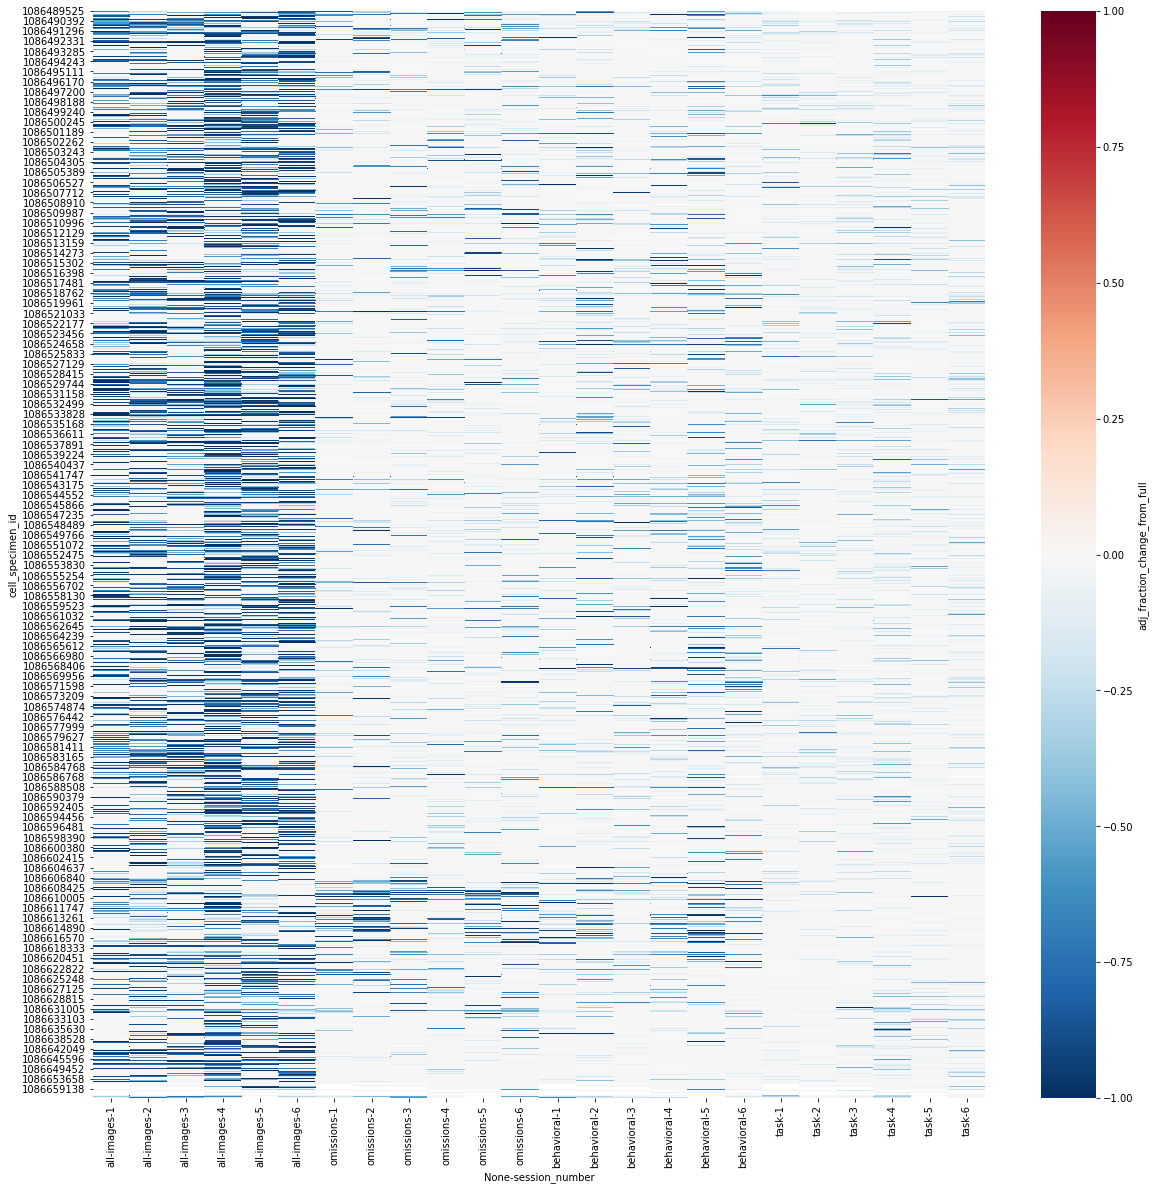

In [21]:
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(df, vmin=-1, vmax=1, center=0, cmap='RdBu_r', ax=ax, cbar_kws={'label':model_output_type})

Text(0.5, 1.0, 'GLM dropouts')

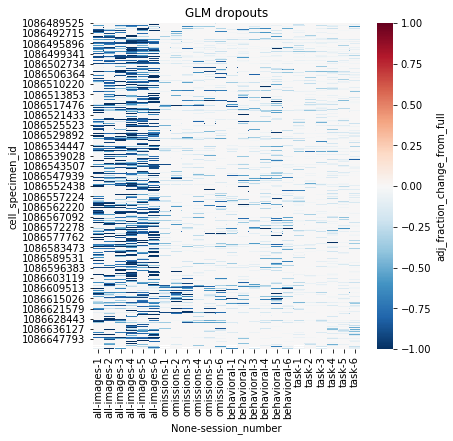

In [22]:
# make smaller plot
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(df, vmin=-1, vmax=1, center=0, cmap='RdBu_r', ax=ax, cbar_kws={'label':model_output_type})
ax.set_title('GLM dropouts')

In [23]:
original_df = df.copy()

#### When a cell was not matched in a given session, its dropout scores for that session are NaN
#### Set all Nans to zero so that we can actually work with this df (otherwise we would have to drop cells that werent in all 6 sessions)

In [24]:
# first flip the sign of the dropouts so they are positive
df = df.abs()

In [25]:
# set NaN values to zero
df[df.isnull()] = 0

Text(0.5, 1.0, 'GLM dropouts')

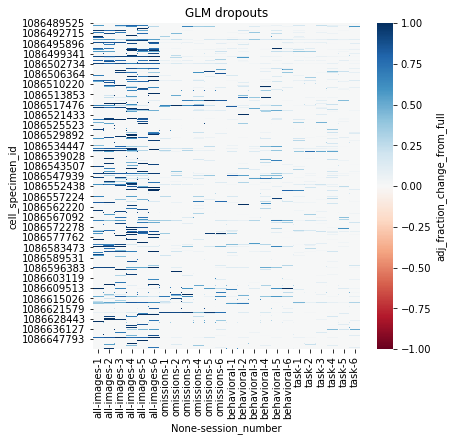

In [26]:
# look at it again
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(df, vmin=-1, vmax=1, center=0, cmap='RdBu', ax=ax, cbar_kws={'label':model_output_type})
ax.set_title('GLM dropouts')

* cells = observations, regressors across sessions = variables / features 
* does this need to be z-scored? or are the values already standardzied? 

### Run PCA on restructured data

In [27]:
from sklearn.decomposition import PCA

features_for_pca = df.columns.values # this is regressors x session numbers

data = df.copy()
data = data.dropna() # shouldnt be any NaNs anymore but lets drop just in case
n_features = len(features_for_pca)
n_components = len(features_for_pca)
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(data.values)
data['pc1'] = pca_result[:,0]
data['pc2'] = pca_result[:,1] 
data['pc3'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
n_pcs_95_pct = np.searchsorted(np.cumsum(pca.explained_variance_ratio_), .95)
print(n_pcs_95_pct, 'PCs explain 95% of the variance')


Explained variation per principal component: [0.28039372 0.14201093 0.10515084 0.08369025 0.06946247 0.06677928
 0.06098864 0.03090971 0.01964286 0.01562054 0.01509486 0.01415394
 0.01347496 0.0127637  0.01087592 0.0102011  0.00960213 0.00868543
 0.00843736 0.00649215 0.00451109 0.00398282 0.00383686 0.00323845]
15 PCs explain 95% of the variance


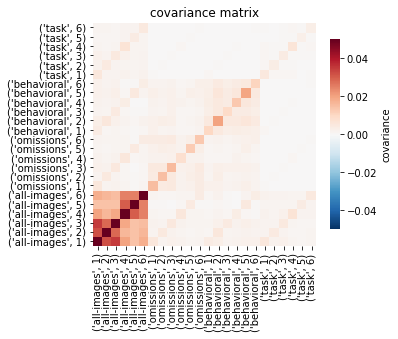

In [28]:
# plot covariance matrix 

fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(pca.get_covariance(), vmin=-0.05, vmax=0.05, cmap='RdBu_r', ax=ax, square=True,
                 robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'covariance'})
ax.set_title('covariance matrix')
ax.set_ylim(0, n_features)
ax.set_xticks(np.arange(0.5, len(features_for_pca)+0.5, 1))
ax.set_xticklabels(features_for_pca, rotation=90);
ax.set_yticklabels(features_for_pca, rotation=0);


Text(0.5, 1.0, 'first 15 PCs explain >95% of the variance')

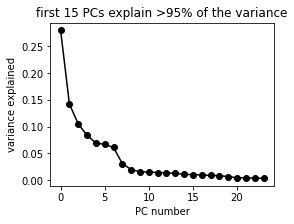

In [29]:
# plot exp var per component

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(np.arange(n_components), pca.explained_variance_ratio_, 'o-k')
ax.set_xlabel('PC number')
ax.set_ylabel('variance explained')
ax.set_title('first '+str(n_pcs_95_pct)+' PCs explain >95% of the variance')


#### Show the feature vector

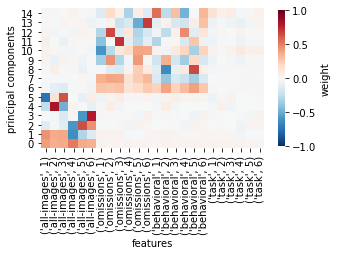

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(pca.components_[:n_pcs_95_pct], vmin=-1, vmax=1, cmap='RdBu_r', ax=ax, square=True,
                 robust=True, cbar_kws={"drawedges": False, "shrink": 0.5, "label": 'weight'})
ax.set_ylabel('principal components')
ax.set_xlabel('features')
# ax.set_title('principal axes in feature space \n(directions of maximum variance in the data)')
ax.set_ylim(0, n_pcs_95_pct)
ax.set_xticks(np.arange(0.5, len(features_for_pca)+0.5, 1))
ax.set_xticklabels(features_for_pca, rotation=90);


#### limit results to the number of PCs explaining 95% variance

In [31]:
pca_result.shape

(24275, 24)

In [32]:
pca_result = pca.fit_transform(data.values)
pca_result = pca_result[:, :n_pcs_95_pct]

In [33]:
pca_result.shape

(24275, 15)

#### look at transformed data (data projected on to PC space)

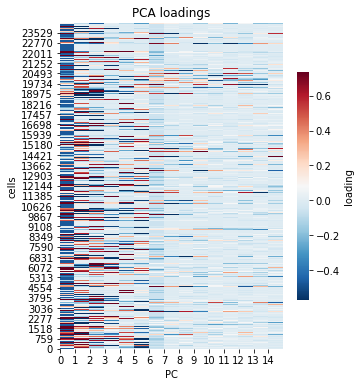

In [34]:
fig, ax = plt.subplots(figsize=(5,6))
ax = sns.heatmap(pca_result, cmap='RdBu_r', ax=ax, 
                 robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'loading'})
ax.set_ylabel('cells')
ax.set_xlabel('PC')
ax.set_title('PCA loadings')
ax.set_ylim(0, pca_result.shape[0])
ax.set_xlim(0, pca_result.shape[1])
ax.set_xticks(np.arange(0, pca_result.shape[1]));
ax.set_xticklabels(np.arange(0, pca_result.shape[1]));

# cluster_divisions = np.where(np.diff(sorted_labels)==1)[0]
# for y in cluster_divisions:
#     ax.hlines(y, xmin=0, xmax=n_components, color='k')

#### add cre line to pca result, drop duplicates

In [35]:
if 'cre_line' not in data.keys():
    data = data.merge(rspm[['cell_specimen_id', 'cre_line']], on='cell_specimen_id')
    data = data.drop_duplicates(subset='cell_specimen_id')
len(data)

C:\Users\iryna.yavorska\Anaconda3\envs\visual_behavior_analysis\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


24275

#### plot data in PC space

ValueError: Length of tuple vectors must match length of `data` when both are used, but `data` has length 24275 and the vector passed to `x` has length 2.

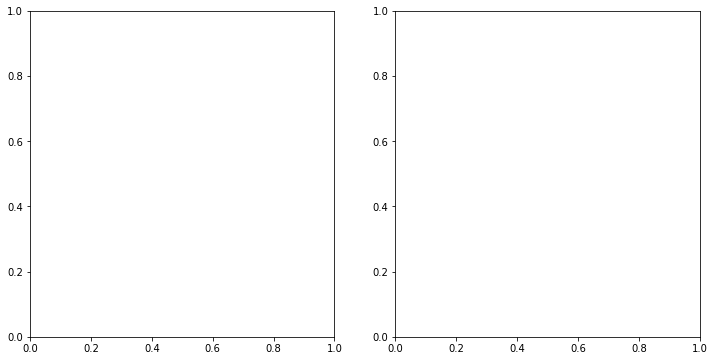

In [36]:
# pc1 and pc2 columns in rspm correspond to pca_results for those PCs - is this the 'score' per cell? 
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0] = sns.scatterplot(data=data, x=("pc1", ""), y=("pc2", ""), hue="cre_line",
    palette='hls', legend="full", alpha=0.3, ax=ax[0])
# ax[0].set_xlim(-5,10)
# ax[0].set_ylim(-5,10)

ax[1] = sns.scatterplot(data=data, x=("pc1", ""), y=("pc2", ""), hue="cre_line",
    palette='hls', legend="full", alpha=0.3, ax=ax[1])
# ax[1].set_xlim(-5,10)
# ax[1].set_ylim(-5,10)

In [37]:
# make a dataframe out of the PCA loadings per cell and add cre line
pca_result_df = pd.DataFrame(pca_result, index=data.index.values)
pca_result_df['cre_line'] = data['cre_line'].values

In [38]:
pca_result_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,cre_line
0,0.350263,-0.427789,1.223064,0.243258,-0.086080,0.011888,0.007149,-0.046570,0.085264,0.023198,-0.032775,0.033791,-0.001750,-0.015200,-0.004284,Slc17a7-IRES2-Cre
3,0.146977,0.000697,0.620307,-0.405385,0.358012,0.040404,0.271417,-0.304379,-0.204367,0.224095,-0.118841,0.089721,-0.155659,0.063175,-0.149249,Slc17a7-IRES2-Cre
7,1.017589,0.919973,0.436747,0.756071,0.316862,-0.550125,-0.105136,0.084742,-0.004657,0.120494,-0.059602,0.046649,0.197738,-0.053916,0.064968,Slc17a7-IRES2-Cre
11,0.016206,0.535332,-0.024757,-0.018799,0.781070,0.143133,-0.150761,0.000541,0.053257,-0.065765,0.016256,-0.004458,-0.035772,-0.005815,0.010040,Slc17a7-IRES2-Cre
14,0.555162,-0.577007,1.550643,0.218977,-0.100601,-0.004681,-0.098442,-0.004150,-0.060575,-0.039466,-0.031026,0.012622,0.043796,-0.025958,-0.029089,Slc17a7-IRES2-Cre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66243,-0.313193,-0.145423,-0.179291,0.008250,0.001267,0.000367,0.019142,-0.054174,0.027462,-0.085183,0.057991,-0.039338,0.113969,-0.049458,-0.110071,Vip-IRES-Cre
66244,-0.472078,0.027673,0.000862,0.005488,-0.006475,-0.005681,-0.057194,-0.003997,0.000040,0.001069,-0.002727,0.002278,-0.000250,0.003346,-0.002470,Vip-IRES-Cre
66245,-0.472078,0.027673,0.000862,0.005488,-0.006475,-0.005681,-0.057194,-0.003997,0.000040,0.001069,-0.002727,0.002278,-0.000250,0.003346,-0.002470,Vip-IRES-Cre
66246,-0.158096,-0.069940,0.399629,0.496888,-0.056807,0.045527,0.001523,-0.060724,0.016734,-0.049259,0.049784,-0.008425,0.047500,0.063204,0.093978,Vip-IRES-Cre


TypeError: object of type 'int' has no len()

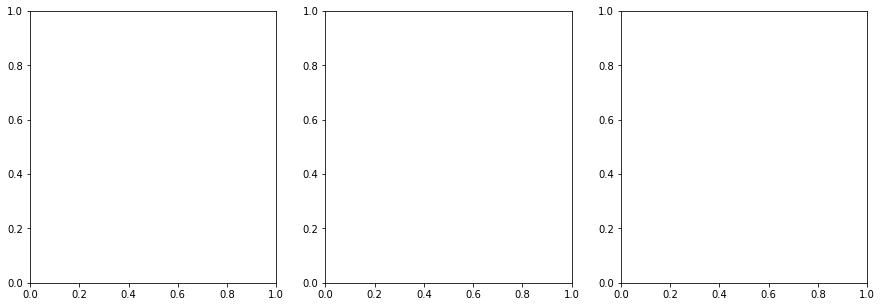

In [41]:
# plot data in PCA space again 

PC1 = 0
PC2 = 1
PC3 = 3
PC4 = 4

fig,ax = plt.subplots(1, 3, figsize=(15,5))
ax = ax.ravel()
i=0
ax[i] = sns.scatterplot(data=pca_result_df, x=PC1, y=PC2, hue="cre_line",
    palette='hls', legend="full", alpha=0.3, ax=ax[i])
# ax[i].set_xlim(-100,100)
# ax[i].set_ylim(-100,100)
i+=1
ax[i] = sns.scatterplot(data=pca_result_df, x=PC2, y=PC3, hue="cre_line",
    palette='hls', legend="full", alpha=0.3, ax=ax[i])
# ax[i].set_xlim(-100,100)
# ax[i].set_ylim(-100,100)
i+=1
ax[i] = sns.scatterplot(data=pca_result_df, x=PC3, y=PC4, hue="cre_line",
    palette='hls', legend="full", alpha=0.3, ax=ax[i])
# ax[i].set_xlim(-100,100)
# ax[i].set_ylim(-100,100)

fig.tight_layout()

### Cluster the PCA result with k-means

#### Choose 10 for K

In [42]:
from sklearn.cluster import KMeans

X = pca_result # cluster the PCA loadings across cells

kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

labels = kmeans.labels_

In [43]:
kmeans.cluster_centers_.shape


(10, 15)

#### Get cluster labels, then sort PCA loadings in cluster order

In [44]:
labels = kmeans.labels_
sort_order = np.argsort(labels)
sorted_labels = labels[sort_order]

In [45]:
pca_result.shape

(24275, 15)

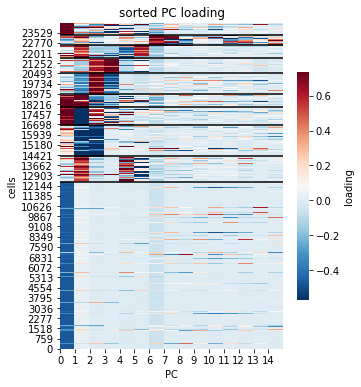

In [46]:
fig, ax = plt.subplots(figsize=(5,6))
ax = sns.heatmap(pca_result[sort_order], cmap='RdBu_r', ax=ax, 
                 robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'loading'})
ax.set_ylabel('cells')
ax.set_xlabel('PC')
ax.set_title('sorted PC loading')
ax.set_ylim(0, pca_result.shape[0])
ax.set_xlim(0, pca_result.shape[1])
ax.set_xticks(np.arange(0, pca_result.shape[1]));
ax.set_xticklabels(np.arange(0, pca_result.shape[1]));

cluster_divisions = np.where(np.diff(sorted_labels)==1)[0]
for y in cluster_divisions:
    ax.hlines(y, xmin=0, xmax=n_components, color='k')

### What is the cre line composition of each cluster? 

In [47]:
cluster_df = pd.DataFrame(index=df.index, columns=['cluster_id'], data=labels)
# merge with metadata
metadata = rspm[['cell_specimen_id', 'cre_line', 'imaging_depth', 'targeted_structure', 'location']]
cluster_df = cluster_df.merge(metadata, on='cell_specimen_id')
cluster_df.head()

,cell_specimen_id,cluster_id,cre_line,imaging_depth,targeted_structure,location
0,1086489525,5,Slc17a7-IRES2-Cre,375,VISp,Slc17a7_VISp_375
1,1086489525,5,Slc17a7-IRES2-Cre,375,VISp,Slc17a7_VISp_375
2,1086489525,5,Slc17a7-IRES2-Cre,375,VISp,Slc17a7_VISp_375
3,1086489529,5,Slc17a7-IRES2-Cre,375,VISp,Slc17a7_VISp_375
4,1086489529,5,Slc17a7-IRES2-Cre,375,VISp,Slc17a7_VISp_375


<AxesSubplot:xlabel='cluster_id', ylabel='count'>

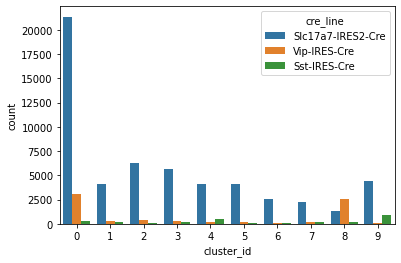

In [48]:
sns.countplot(data=cluster_df, x='cluster_id', hue='cre_line')

### What is the cluster breakdown for each cre line?

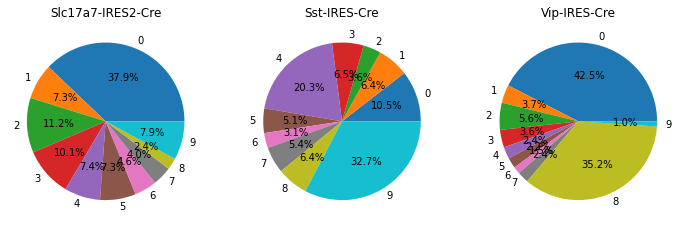

In [49]:
counts = cluster_df.groupby(['cre_line', 'cluster_id']).count().reset_index()
counts = counts.drop_duplicates(subset=['cell_specimen_id', 'cre_line'])

fig, ax = plt.subplots(1,3, figsize=(12,5))
for i,cre_line in enumerate(np.sort(cluster_df.cre_line.unique())):
    ax[i].pie(counts[counts.cre_line==cre_line].cell_specimen_id.values, 
              labels=np.sort(cluster_df.cluster_id.unique()), autopct='%1.1f%%')
    ax[i].set_title(cre_line)

### Look at coding properties of clusters

#### add cluster IDs to the original dataframe of dropout scores and plot average dropout by session for each cluster

In [50]:
cluster_ids = pd.DataFrame(index=df.index, columns=['cluster_id'], data=labels)

rspm = rspm.merge(cluster_ids, on='cell_specimen_id')

for each cluster, look at average dropout for all features, for each session type

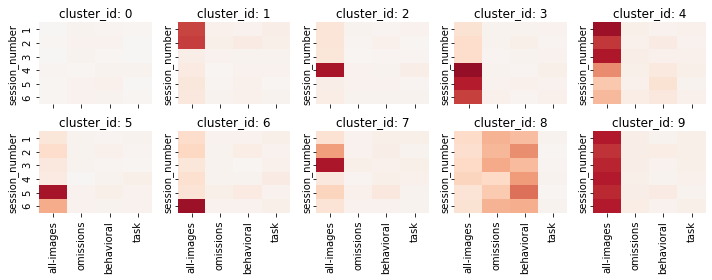

In [51]:
cluster_ids = np.sort(rspm.cluster_id.unique())
n_rows = int(len(cluster_ids)/5.)
fig, ax = plt.subplots(n_rows, 5, figsize=(10,2*n_rows), sharex=True, sharey=True)
ax = ax.ravel()
for i,cluster_id in enumerate(cluster_ids):
    mean_dropouts_for_cluster = rspm[rspm.cluster_id==cluster_id].groupby('session_number').mean()[features_to_plot]
    ax[i] = sns.heatmap(mean_dropouts_for_cluster, cmap='RdBu', vmin=-1, vmax=1, ax=ax[i], cbar=False, cbar_kws={'label':model_output_type})
    ax[i].set_title('cluster_id: '+str(cluster_id))
#     ax[i].set_
fig.tight_layout()

### what do individual cell dropout scores across sessions look like? do they line up with these clusters? 

#### turn data into a 3D array of n_cells x n_features x n_sessions

In [52]:
arr = original_df.values
arr = np.abs(arr)
arr.shape

(24275, 24)

In [53]:
arr = arr.reshape(-1,4,6)
arr.shape

(24275, 4, 6)

In [54]:
# make NaNs zero
arr[np.isnan(arr)] = 0

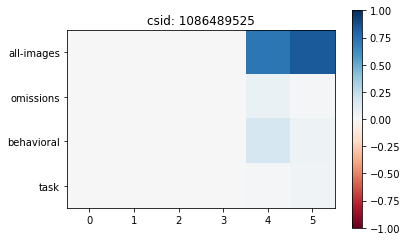

In [55]:
# plot dropouts across sessions for one cell
cell_index = 0
plt.imshow(arr[cell_index, :, :], cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(np.arange(0,6,1))
plt.yticks(np.arange(0,len(features_to_plot),1), labels=features_to_plot)
plt.title('csid: '+str(cell_specimen_ids[cell_index]))
plt.colorbar()

In [56]:
# get 100 random cells
inds = len(cell_specimen_ids)*np.random.random_sample(size=100)
random_indices = [int(ind) for ind in inds]

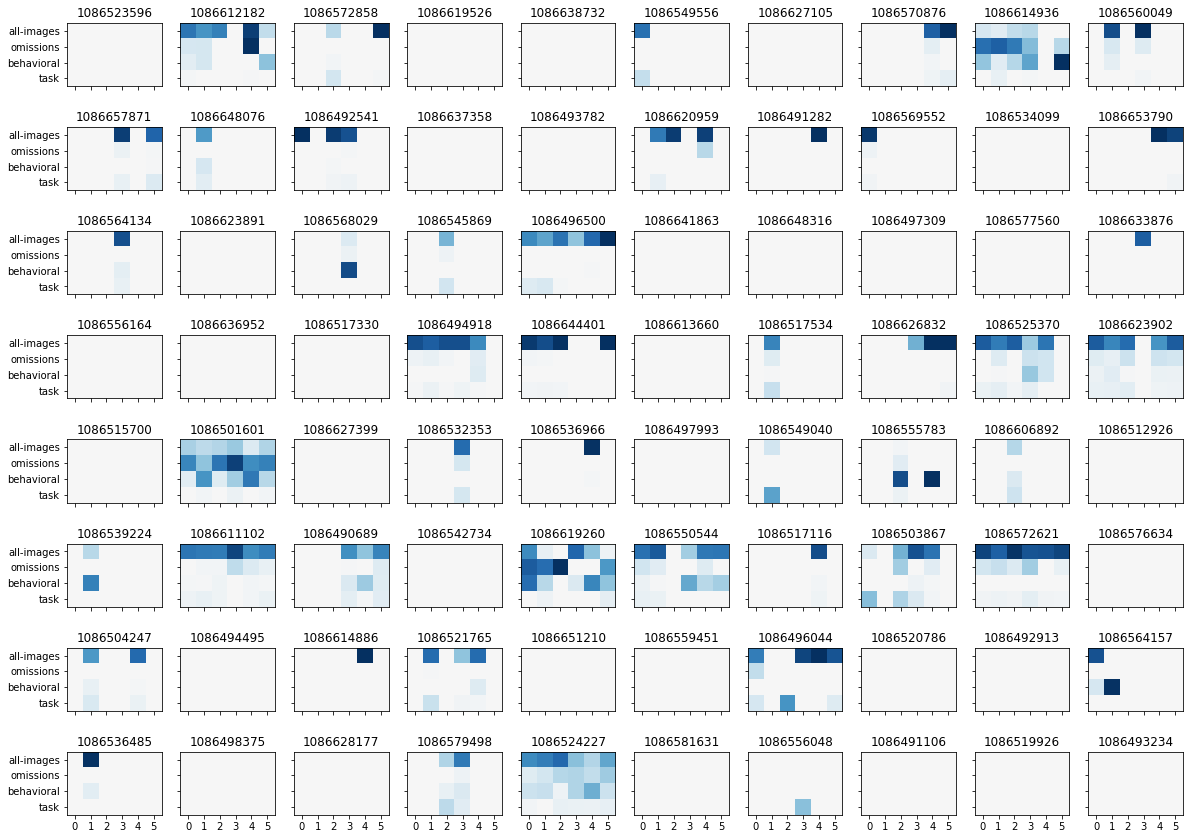

In [57]:
# plot for a bunch of random cells
cell_index = 0
fig, ax = plt.subplots(8,10, figsize=(20,15), sharex=True, sharey=True)
ax = ax.ravel()
for i,cell_index in enumerate(random_indices[:80]): 
    ax[i].imshow(arr[cell_index, :, :], cmap='RdBu', vmin=-1, vmax=1)
    ax[i].set_xticks(np.arange(0,6,1))
    ax[i].set_yticks(np.arange(0,len(features_to_plot),1))
    ax[i].set_yticklabels(features_to_plot)
    ax[i].set_title(str(cell_specimen_ids[cell_index]))
#     ax[i].colorbar()

Cells primarily care about images in specific sessions, with some weak coding for behavioral and task variables

# PCA & k-means on each cre line

In [58]:
def plot_PCA_var_explained(pca, n_components, cre_line):
    
    n_PCs_95pct_var = np.searchsorted(np.cumsum(pca.explained_variance_ratio_), .95)

    fig,ax=plt.subplots(figsize=(4,3))
    ax.plot(
        np.arange(n_components),
        pca.explained_variance_ratio_,
        'o-k'
    )
    ax.set_xlabel('PC number')
    ax.set_ylabel('variance explained')
    ax.set_title(cre_line+', first '+str(n_PCs_95pct_var)+' PCs explain >95% of the variance')


In [59]:
def plot_input_to_PCA(data, cre_line, features_for_pca, model_output_type):
    fig, ax = plt.subplots(figsize=(5,6))
    ax = sns.heatmap(data=data[features_for_pca], cmap='RdBu', ax=ax, vmin=-1, vmax=1,
                     robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": model_output_type})
    ax.set_ylabel('cells')
    ax.set_xlabel('features')
    ax.set_title(cre_line)
    ax.set_ylim(0, data.shape[0])
    ax.set_xlim(0, data.shape[1])
    ax.set_xticks(np.arange(0, data.shape[1], 1));
    ax.set_xticklabels(features_for_pca);
    
def plot_covariance_matrix(pca, features_for_pca, n_features):
    fig, ax = plt.subplots(figsize=(5,5))
    ax = sns.heatmap(pca.get_covariance(), vmin=-0.05, vmax=0.05, cmap='RdBu_r', ax=ax, square=True,
                     robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'covariance'})
    ax.set_title('covariance matrix')
    ax.set_ylim(0, n_features)
    ax.set_xticks(np.arange(0.5, len(features_for_pca)+0.5, 1))
    ax.set_xticklabels(features_for_pca, rotation=90);
    ax.set_yticklabels(features_for_pca, rotation=0);

    
def plot_PCs_by_features(pca, n_components, features_to_plot, cre_line, n_pcs_95_pct, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(figsize=(5,5))
    ax = sns.heatmap(pca.components_[:n_pcs_95_pct], vmin=-1, vmax=1, cmap='RdBu_r', ax=ax, square=True,
                     robust=True, cbar_kws={"drawedges": False, "shrink": 0.5, "label": 'weight'})
    ax.set_ylabel('principal components')
    ax.set_xlabel('features')
    ax.set_title(cre_line)
    ax.set_ylim(0, n_pcs_95_pct)
#     ax.set_yticks(np.arange(0, n_components, 1))
#     ax.set_yticklabels(np.arange(0.5, n_components+0.5, 1), rotation=90);
    ax.set_xticks(np.arange(0.5, len(features_to_plot)+0.5, 1))
    ax.set_xticklabels(features_to_plot, rotation=90);
    return ax

In [60]:
# pc1 and pc2 columns in rspm correspond to pca_results for those PCs - is this the 'score' per cell? 

def plot_data_in_PC_space(pca_result_df, cre_line):
    PC1 = 'PC0'
    PC2 = 'PC1'
    PC3 = 'PC2'
    PC4 = 'PC3'
    PC5 = 'PC4'
    PC6 = 'PC5'

    fig,ax = plt.subplots(2, 3, figsize=(12,8))
    ax = ax.ravel()
    i=0
    ax[i] = sns.scatterplot(data=pca_result_df, x=PC1, y=PC2, #hue="cre_line",
        legend="full", alpha=0.3, ax=ax[i])
    i+=1
    ax[i] = sns.scatterplot(data=pca_result_df, x=PC2, y=PC3, #hue="cre_line",
        legend="full", alpha=0.3, ax=ax[i])
    i+=1
    ax[i] = sns.scatterplot(data=pca_result_df, x=PC3, y=PC4, #hue="cre_line",
        legend="full", alpha=0.3, ax=ax[i])
    i+=1
    ax[i] = sns.scatterplot(data=pca_result_df, x=PC4, y=PC5, #hue="cre_line",
        legend="full", alpha=0.3, ax=ax[i])
    i+=1
    ax[i] = sns.scatterplot(data=pca_result_df, x=PC5, y=PC6, #hue="cre_line",
        legend="full", alpha=0.3, ax=ax[i])
    i+=1
    ax[i] = sns.scatterplot(data=pca_result_df, x=PC1, y=PC6, #hue="cre_line",
        legend="full", alpha=0.3, ax=ax[i])

    fig.tight_layout()
    fig.suptitle(cre_line, x=0.5, y=1.01)

In [61]:
def plot_PCA_result_heatmap(pca_result, cre_line):
    fig, ax = plt.subplots(figsize=(5,6))
    ax = sns.heatmap(pca_result, cmap='RdBu_r', ax=ax, 
                     robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'activation'})
    ax.set_ylabel('cells')
    ax.set_xlabel('PC')
    ax.set_title(cre_line)
    ax.set_ylim(0, pca_result.shape[0])
    ax.set_xlim(0, pca_result.shape[1])
    ax.set_xticks(np.arange(0, pca_result.shape[1], 1));
    ax.set_xticklabels(np.arange(0, pca_result.shape[1], 1));

In [62]:

# cluster 
def cluster_pca_result_kmeans(pca_result, n_clusters=10):
    from sklearn.cluster import KMeans
    X = pca_result

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

    labels = kmeans.labels_
    
    return kmeans, labels


# plot sorted PC weights 
def plot_sorted_PC_weights(pca_result, labels):
    
    sort_order = np.argsort(labels)
    sorted_labels = labels[sort_order]

    fig, ax = plt.subplots(figsize=(5,6))
    ax = sns.heatmap(pca_result[sort_order], cmap='RdBu_r', ax=ax, vmin=-1, vmax=1,
                     robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'loading'})
    ax.set_ylabel('cells')
    ax.set_xlabel('PC')
    ax.set_title(cre_line)
    ax.set_ylim(0, pca_result.shape[0])
    ax.set_xlim(0, pca_result.shape[1])
    ax.set_xticks(np.arange(0, pca_result.shape[1]));
    # ax.set_xticklabels(features_for_pca, rotation=90);

    cluster_divisions = np.where(np.diff(sorted_labels)==1)[0]
    for y in cluster_divisions:
        ax.hlines(y, xmin=0, xmax=n_components, color='k')

        
def create_cluster_df(df, rspm, labels):
    # cluster df 
    cluster_df = pd.DataFrame(index=df.index, columns=['cluster_id'], data=labels)
    # merge with metadata
    metadata = rspm[['cell_specimen_id', 'cre_line', 'imaging_depth', 'targeted_structure', 'location']]
    cluster_df = cluster_df.merge(metadata, on='cell_specimen_id')
    cluster_df = cluster_df.drop_duplicates(subset=['cell_specimen_id', 'cre_line'])
    return cluster_df 


def plot_cluster_pie_for_cre_line(cluster_df, cre_line):
    counts = cluster_df.groupby(['cre_line', 'cluster_id']).count().reset_index()

    fig, ax = plt.subplots(figsize=(4,4))
    ax.pie(counts[counts.cre_line==cre_line].cell_specimen_id.values, 
              labels=np.sort(cluster_df.cluster_id.unique()), autopct='%1.1f%%')
    ax.set_title(cre_line)
    
    
# coding properties of clusters
def plot_coding_properties_of_clusters(cre_data, labels, rspm, cre_line, features_to_plot):

    cluster_ids = pd.DataFrame(index=cre_data.index, columns=['cluster_id'], data=labels)

    cre_rspm = rspm[rspm.cre_line==cre_line]
    if 'cluster_id' in rspm.keys():
        cre_rspm = cre_rspm.drop(columns=['cluster_id'])
    cre_rspm = cre_rspm.merge(cluster_ids, on='cell_specimen_id')

    cluster_ids = np.sort(cre_rspm.cluster_id.unique())
    n_rows = int(len(cluster_ids)/5.)
    fig, ax = plt.subplots(n_rows, 5, figsize=(10,2*n_rows), sharex=True, sharey=True)
    ax = ax.ravel()
    for i,cluster_id in enumerate(cluster_ids):
        mean_dropouts_for_cluster = cre_rspm[cre_rspm.cluster_id==cluster_id].groupby('session_number').mean()[features_to_plot]
        ax[i] = sns.heatmap(mean_dropouts_for_cluster, cmap='RdBu', vmin=-1, vmax=1, ax=ax[i], cbar=False, cbar_kws={'label':model_output_type})
        ax[i].set_title('cluster_id: '+str(cluster_id))
    #     ax[i].set_
    fig.tight_layout()


#### PCA plots per cre line

In [63]:
if 'cre_line' not in data.keys():
    data = data.merge(rspm[['cell_specimen_id','cre_line']], on='cell_specimen_id')
    data = data.drop_duplicates(subset='cell_specimen_id')
print(len(data))

24275


In [64]:
features_for_pca = df.keys()

### Selecting K

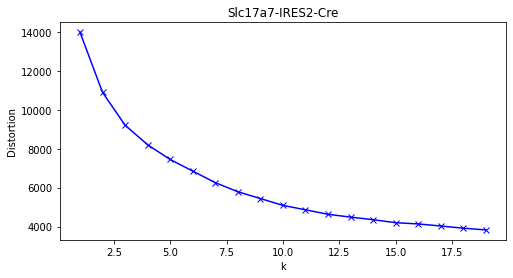

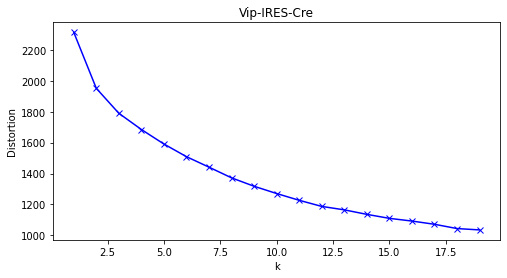

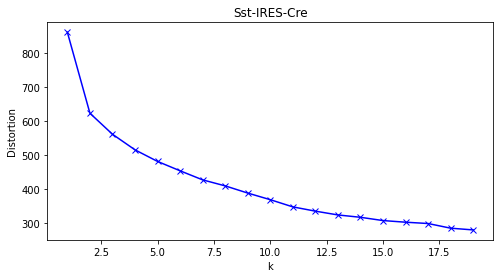

In [65]:
# elbow method plots

for cre_line in data.cre_line.unique():
    cre_data = data[data.cre_line==cre_line]
    cre_data = cre_data.dropna()
    n_features = len(features_for_pca)
    n_components = len(features_for_pca)
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(cre_data[features_for_pca].values)
    
    distortions = []
    K = range(1,20)
    for k in K:
        kmeans, labels = cluster_pca_result_kmeans(pca_result, n_clusters=k)
        distortions.append(kmeans.inertia_)
        
    fig, ax = plt.subplots(figsize = (8,4))
    ax.plot(K, distortions, 'bx-')
    ax.set_xlabel('k')
    ax.set_ylabel('Distortion')
    ax.set_title(cre_line)

### Plot all figures for each cre line

Slc17a7-IRES2-Cre
14 PCs explain 95% of the variance
Vip-IRES-Cre
15 PCs explain 95% of the variance
Sst-IRES-Cre
13 PCs explain 95% of the variance


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and m

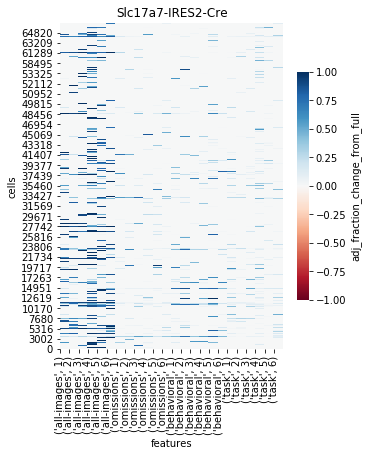

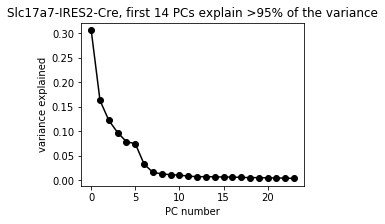

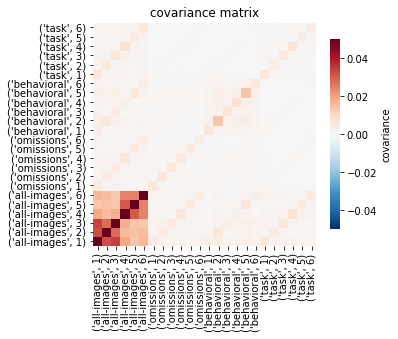

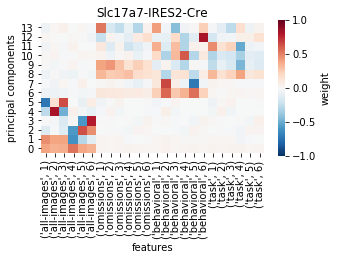

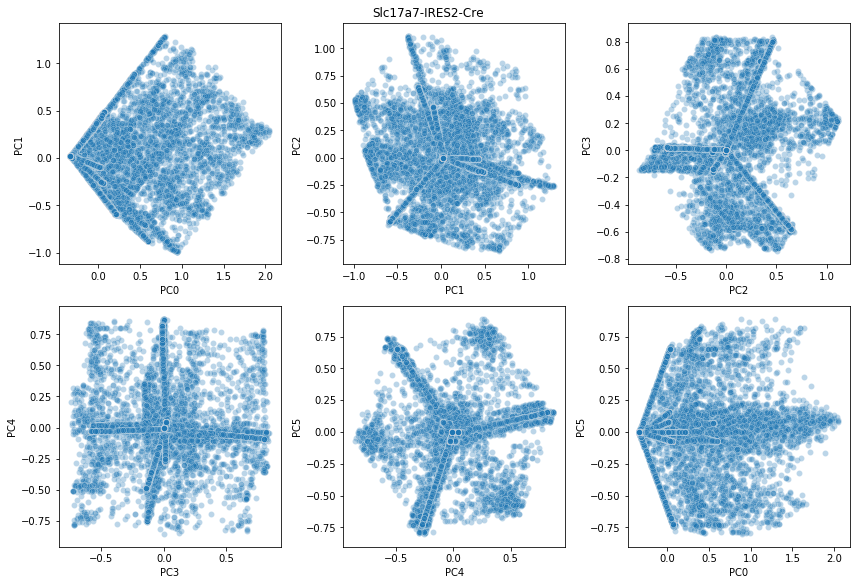

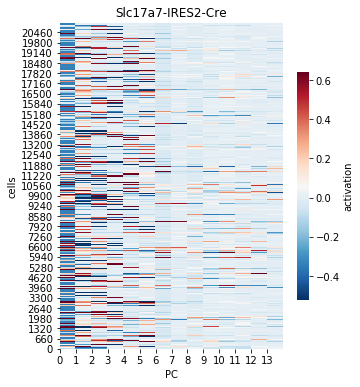

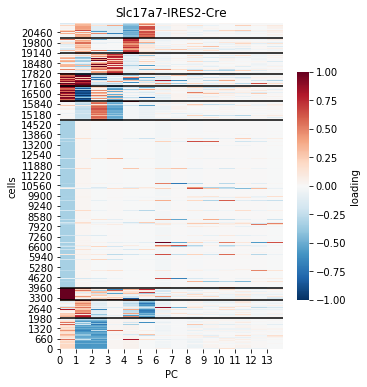

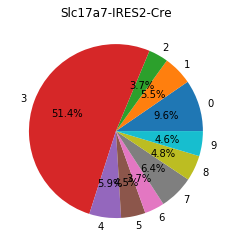

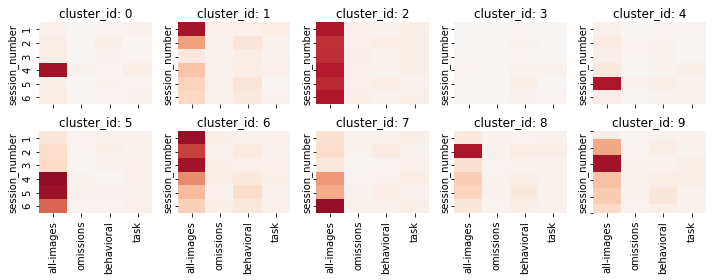

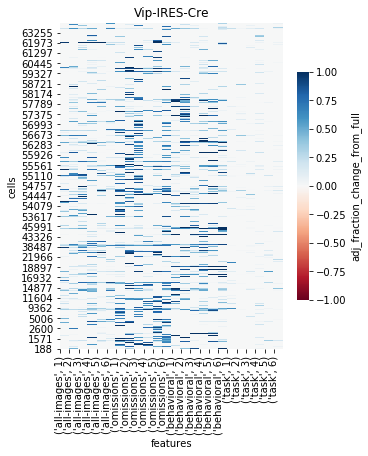

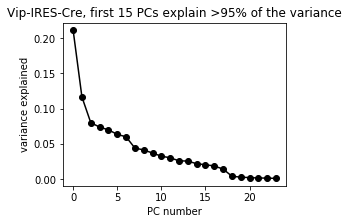

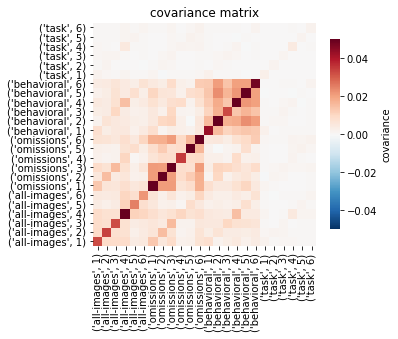

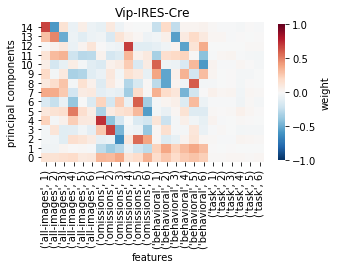

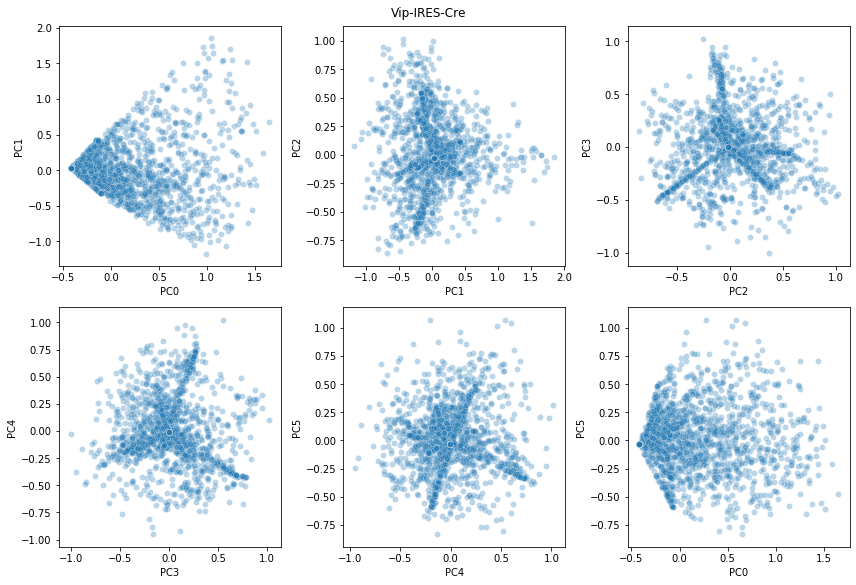

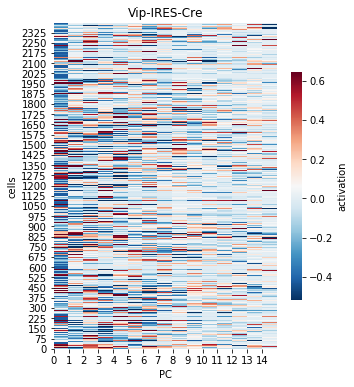

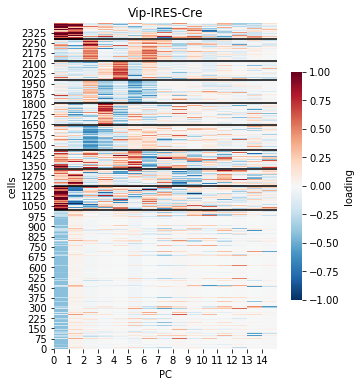

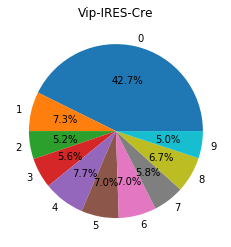

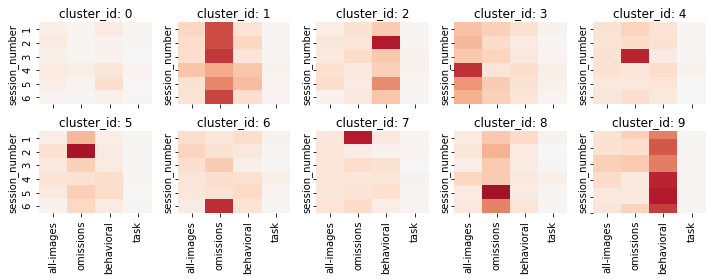

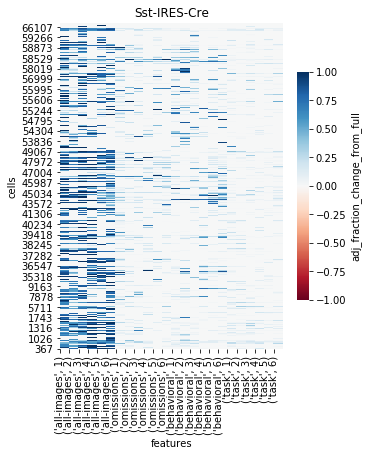

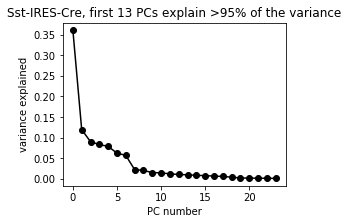

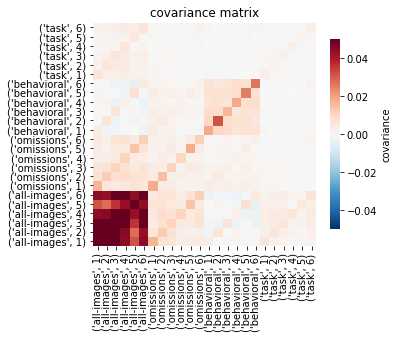

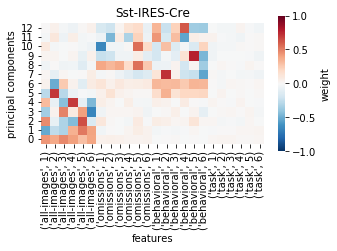

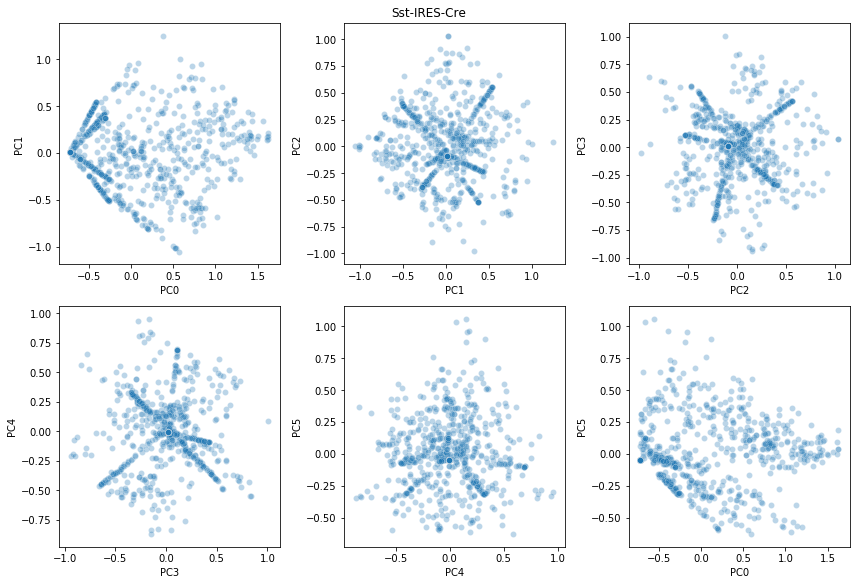

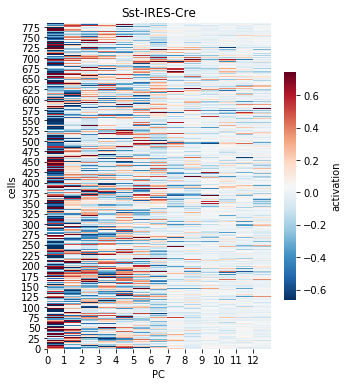

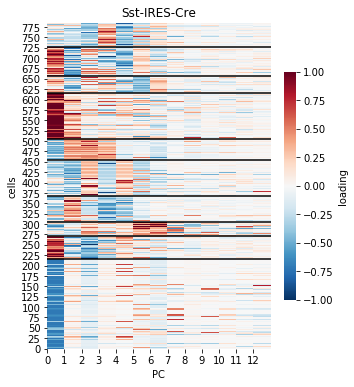

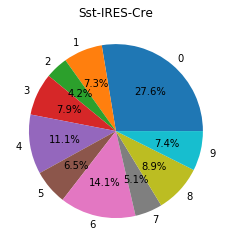

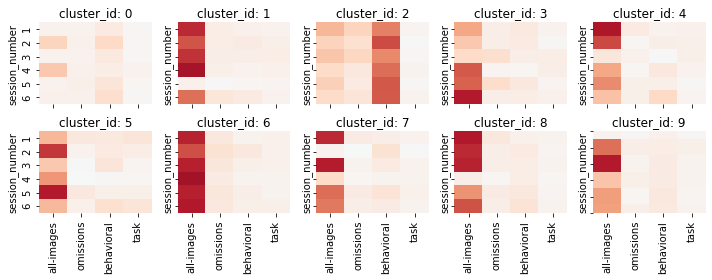

In [64]:
full_cluster_df = pd.DataFrame()
for cre_line in data.cre_line.unique():
    print(cre_line)
    cre_data = data[data.cre_line==cre_line]
    cre_data = cre_data.dropna()
    n_features = len(features_for_pca)
    n_components = len(features_for_pca)
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(cre_data[features_for_pca].values)
    cre_data['pc1'] = pca_result[:,0]
    cre_data['pc2'] = pca_result[:,1] 
    cre_data['pc3'] = pca_result[:,2]
    n_pcs_95_pct = np.searchsorted(np.cumsum(pca.explained_variance_ratio_), .95)
    print(n_pcs_95_pct, 'PCs explain 95% of the variance')
    pca_result = pca_result[:,:n_pcs_95_pct]
    
    # plot input matrix
    plot_input_to_PCA(cre_data[features_for_pca], cre_line, features_for_pca, model_output_type)
    
    # variance explained plot
    plot_PCA_var_explained(pca, n_components, cre_line)
    
    # plot covariance matrix
    plot_covariance_matrix(pca, features_for_pca, n_features)
    
    # PCs by features heatmap
    plot_PCs_by_features(pca, n_components, features_for_pca, cre_line, n_pcs_95_pct)
    
    # data in PC space
    pca_result_df = pd.DataFrame(pca_result, index=cre_data.index, columns = ['PC'+str(i) for i in range(n_pcs_95_pct)])
    plot_data_in_PC_space(pca_result_df, cre_line)
    
    # plot PCA weights by cells
    plot_PCA_result_heatmap(pca_result, cre_line)
    
    # cluster and plot PCA weights by clusters
    kmeans, labels = cluster_pca_result_kmeans(pca_result, n_clusters=10)
    plot_sorted_PC_weights(pca_result, labels)

    try:
        cre_data = cre_data.set_index('cell_specimen_id')
    except:
        pass

    # plot cluster breakdown within cre line
    cluster_df = create_cluster_df(cre_data, rspm, labels)
    full_cluster_df = pd.concat([full_cluster_df, cluster_df])
    plot_cluster_pie_for_cre_line(cluster_df, cre_line)

    # plot coding properties for clusters
    plot_coding_properties_of_clusters(cre_data, labels, rspm, cre_line, features_to_plot)

In [65]:
len(full_cluster_df)

24275

In [66]:
len(rspm.cell_specimen_id.unique())

24275

### plot timeseries for clusters 

#### load cached multi session dataframes with event locked traces

In [68]:
experiments_table = loading.get_filtered_ophys_experiment_table(release_data_only=True)

In [69]:
cache_dir = loading.get_analysis_cache_dir()
df_name = 'omission_response_df'
conditions = ['cell_specimen_id']

use_events = False

multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments_table, 
                                                remove_outliers=True, use_events=use_events)
multi_session_df = multi_session_df.reset_index().drop(columns='index')
multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(experiments_table.index)]

# remove novel session retakes
indices = multi_session_df[(multi_session_df.session_number==4)&(multi_session_df.prior_exposures_to_image_set!=0)].index
multi_session_df = multi_session_df.drop(index=indices)
multi_session_df = multi_session_df.reset_index(drop=True)


omission_response_df = multi_session_df.copy()
# indices = [index for index in multi_session_df.index if len(multi_session_df.iloc[index].mean_trace) == 37]
# multi_session_df = multi_session_df.loc[indices]

no multi_session_df for OPHYS_6_images_A
no multi_session_df for OPHYS_6_images_H


In [70]:
def plot_mean_trace(traces, timestamps, ylabel='dF/F', legend_label=None, color='k', interval_sec=1, xlim_seconds=[-2,2],
                    plot_sem=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    if len(traces) > 0:
        trace = np.mean(traces, axis=0)
        sem = (traces.std()) / np.sqrt(float(len(traces)))
        ax.plot(timestamps, trace, label=legend_label, linewidth=2, color=color)
        if plot_sem:
            ax.fill_between(timestamps, trace + sem, trace - sem, alpha=0.5, color=color)
        ax.set_xticks(np.arange(int(timestamps[0]), int(timestamps[-1]), interval_sec))
        ax.set_xlim(xlim_seconds)
        ax.set_xlabel('time (sec)')
        ax.set_ylabel(ylabel)
    sns.despine(ax=ax)
    return ax

In [77]:
def plot_population_average_for_condition(multi_session_df, timestamps, condition_name,  project_codes, data_type, 
                                       change=True, omitted=False, colors=None, ax=None, title='title',
                                                           xlim_seconds=None, save_dir=None, folder=None):
    if colors is None:
        c = utils.get_colors_for_session_numbers()
        colors = [c[0], c[3]]

    sdf = multi_session_df.copy()
    sdf = sdf[sdf.project_code.isin(project_codes)]

    # remove traces with incorrect length - why does this happen?
    sdf = sdf.reset_index(drop=True)
    indices = [index for index in sdf.index if len(sdf.iloc[index].mean_trace) == len(sdf.mean_trace.values[0])]
    sdf = sdf.loc[indices]
    
    if xlim_seconds is None: 
        xlim_seconds = [timestamps[0], timestamps[-1]]
    if 'events' in data_type:
        ylabel = 'response'
    elif 'dFF' in data_type:
        ylabel = 'dF/F'
    elif 'pupil_area' in data_type: 
        ylabel = 'pupil area (pix^2)'
    elif 'running' in data_type:
        ylabel = 'running speed (cm/s)'
    if len(project_codes) == 1:
        project_code = project_codes[0]
    elif len(project_codes) == 2: 
        project_code = 'Scientifica'
    else: 
        project_code = 'all'
    if xlim_seconds[0]<=1:
        interval_sec=0.5
    else:
        interval_sec=1

    if ax is None: 
        figsize = (6,4)
        fig, ax = plt.subplots(figsize=figsize, sharey=False)
#     for i,cre_line in enumerate(np.sort(sdf.cre_line.unique())):
    for c, condition in enumerate(np.sort(sdf[condition_name].unique())):
        traces = sdf[(sdf[condition_name]==condition)].mean_trace.values
#             traces = [trace for trace in traces if np.amax(trace) < 4]
        ax = plot_mean_trace(np.asarray(traces), timestamps, ylabel=ylabel, 
                                            legend_label=condition, color=colors[c], interval_sec=interval_sec,
                                            xlim_seconds=xlim_seconds, ax=ax)
    ax = utils.plot_flashes_on_trace(ax, timestamps, change=change, omitted=omitted)
    ax.axvline(x=0, ymin=0, ymax=1, linestyle='--', color='gray')
    ax.set_title(title)
#             ax[i].get_legend().remove()
    ax.set_xlim(xlim_seconds)
    ax.set_xlabel('time relative to omission (sec)')
#         ax[i].legend(loc='top left', title=condition_name, fontsize='x-small', title_fontsize='x-small')
    ax.set_ylabel(ylabel)
#     plt.suptitle('population average omission response', x=0.5, y=1.03, fontsize=18)
    if save_dir:
        fig.tight_layout()
        fig_title = data_type+'_'+project_code[14:]+condition_name+'_by_cre_line'
        utils.save_figure(fig, figsize, save_dir, folder, fig_title)
    return ax

In [72]:
change = False
omitted = True
folder = 'omissions'

In [73]:
multiscope_expt = experiments_table[experiments_table.project_code=='VisualBehaviorMultiscope'].index.values[9] 
scientifica_expt = experiments_table[experiments_table.project_code=='VisualBehavior'].index.values[9] 

experiment_id = scientifica_expt

from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

dataset = loading.get_ophys_dataset(experiment_id)
# dataset = cache.get_behavior_ophys_experiment(scientifica_expt)
analysis = ResponseAnalysis(dataset)
tmp = analysis.get_response_df(df_name='omission_response_df')
scientifica_timestamps = tmp.trace_timestamps.values[0]
print(len(scientifica_timestamps))

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


309


In [74]:
import visual_behavior.visualization.utils as utils


In [75]:
save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\summary_plots\population_plots\population_averages'

data_type = 'dFF_all_stim_clusters'
project_codes = ['VisualBehavior', 'VisualBehaviorTask1B']
timestamps = scientifica_timestamps
condition_name = 'session_number'
xlim_seconds = [-1,2]

sdf = multi_session_df.copy()
sdf = sdf[sdf.project_code.isin(project_codes)]

colors = utils.get_colors_for_session_numbers()


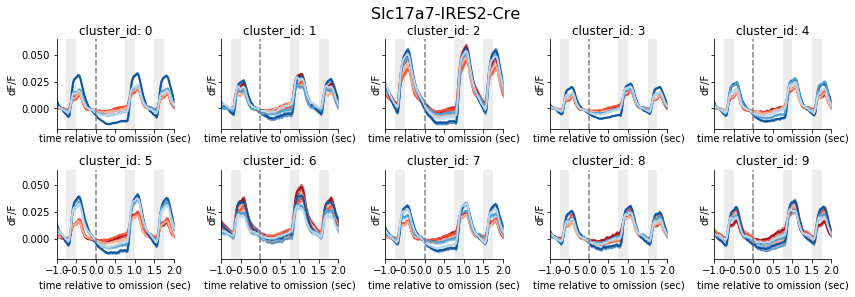

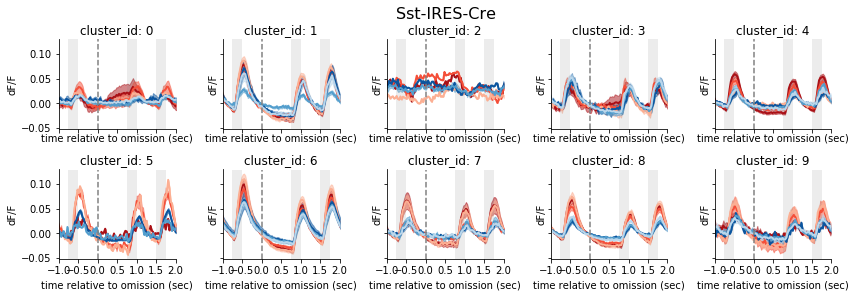

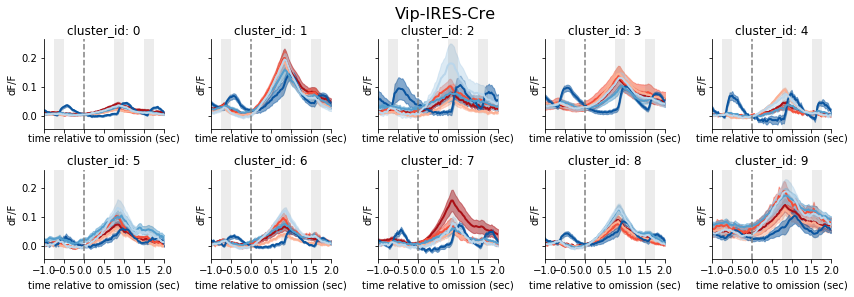

In [78]:
for c,cre_line in enumerate(np.sort(full_cluster_df.cre_line.unique())):
    fig, ax = plt.subplots(2, 5, figsize=(12,4), sharex=True, sharey=True)
    ax = ax.ravel()
    for i, cluster_id in enumerate(np.sort(full_cluster_df.cluster_id.unique())):
        cell_specimen_ids = full_cluster_df[(full_cluster_df.cre_line==cre_line)&(full_cluster_df.cluster_id==cluster_id)].cell_specimen_id.unique()
        tmp = sdf[(sdf.cell_specimen_id.isin(cell_specimen_ids))]
        ax[i] = plot_population_average_for_condition(tmp, timestamps, condition_name,  project_codes, data_type, 
                                               change=change, omitted=omitted, colors=colors, ax=ax[i], 
                                                      title = 'cluster_id: '+str(cluster_id), 
                                                        xlim_seconds=xlim_seconds, save_dir=None, folder=folder)
    plt.suptitle(cre_line, x=0.52, y=1.02, fontsize=16)    
    fig.tight_layout()

### Next steps

* single cell examples of changes across sessions - heatmaps of dropout scores plus average image and omission trace per session to confirm that the pattern of chanes in dropout sores reflects changes in the actual cell activity (harder to do for behavioral & task but could compare running vs not running or hit vs miss or make some lick or running triggered averages)
* plot other properties for each cluster - image selectivity, reliability, etc
* quantify breakdown of clusters by area & depth 
* decide what to do about cells not matched in all sessions
* cluster on concatenated average dFF trace (or GLM kernels)across sesssions, see how it compares to clusters from dropout scores - do clusters based on changes in dynamics align with clusters based on changes in coding? 
